**Getting Foolbox and other toolkits to perform the attack mentioned
Testing code available at**   :  https://colab.research.google.com/github/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb#scrollTo=f-prR7akVTVD

In [ ]:
!pip install foolbox
import foolbox as fb
import eagerpy as ep
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import tensorflow as tf
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


**Loding Model for Testing the code**

In [ ]:
model = tf.keras.applications.MobileNetV2(weights="imagenet")


14536120/14536120 [==============================] - 0s 0us/step


**Turn your PyTorch / TensorFlow model into a Foolbox model**

In [ ]:
preprocessing = dict()
bounds = (-1, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


**Transform bounds**

In [ ]:
fmodel = fmodel.transform_bounds((0, 1))
assert fmodel.bounds == (0, 1)

**Get some test images to check**

In [ ]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

**Check the accuracy of your model to make sure you specified the correct preprocessing**

In [ ]:
fb.utils.accuracy(fmodel, images, labels)

0.9375

**Running LinfDeepFool**

In [ ]:
attack = fb.attacks.LinfDeepFoolAttack()

**Use EagerPy tensors and rerun the attack**

In [ ]:
import eagerpy as ep
images = ep.astensor(images)
labels = ep.astensor(labels)
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)

**Using the Misclassification criterion explicitly**

In [ ]:
criterion = fb.criteria.Misclassification(labels)
raw, clipped, is_adv = attack(fmodel, images, criterion, epsilons=0.03)
is_adv

TensorFlowTensor(<tf.Tensor: shape=(16,), dtype=bool, numpy=
                 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                         True,  True,  True,  True,  True,  True,  True])>)

**Run the attack using multiple epsilons**

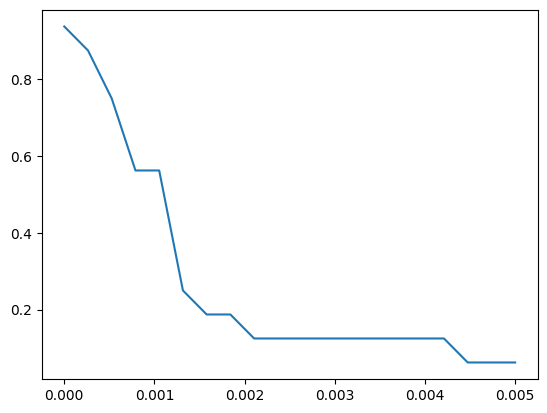

In [ ]:
epsilons = np.linspace(0.0, 0.005, num=20)
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
plt.plot(epsilons, robust_accuracy.numpy())

**Visualizing adversarial examples and perturbations**

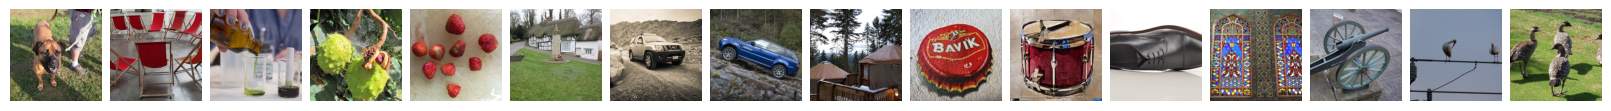

In [ ]:
type(images)
fb.plot.images(images)

In [ ]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [ ]:
for adv_example in advs:
    adv_numpy = adv_example.raw.numpy()
    fb.plot.images(adv_numpy)






**Reimplementation of the same attack shown above with Enhanced parameter**

In [ ]:

# Before attack accuracy check
def check_main_accuracy(fmodel, images, labels):
    accuracy = fb.utils.accuracy(fmodel, images, labels)
    return accuracy

# Purtubation attack using epsilon
def perform_epsilon_perturbation(fmodel, images, labels, epsilon):
    attack = fb.attacks.LinfDeepFoolAttack()
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilon)
    return is_adv

# Targated Attack
def perform_targeted_attack(fmodel, images, target_classes, epsilons):
    criterion = fb.criteria.TargetedMisclassification(target_classes)
    attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
    #attack = fb.attacks.L2CarliniWagnerAttack(steps=100,binary_search_steps=20)    #Enchancement made with Binary Search Step Size
    epsilons = None
    advs, _, is_adv = attack(fmodel, images, criterion,epsilons=epsilons)
    return is_adv

# Function to plot accuracy
def plot_accuracy(before_accuracy, after_accuracy, title):
    plt.plot(before_accuracy, label='Before Attack')
    plt.plot(after_accuracy, label='After Attack')
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

# Get all models and store in form of list
models = [
    torchvision.models.resnet18(pretrained=True),
    tf.keras.applications.ResNet50(weights="imagenet")
]

main_accuracy_before = []
main_accuracy_after = []

for model in models:
    # Convert the model to Foolbox model
    if isinstance(model, torch.nn.Module):
        preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
        bounds = (0, 1)
        fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)
    elif isinstance(model, tf.keras.Model):
        preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
        bounds = (0, 255)
        fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

    # Small batch to test the pretrained model
    images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

    # pre accuracy chek call
    accuracy_before = check_main_accuracy(fmodel, images, labels)
    main_accuracy_before.append(accuracy_before)


    # perform epsilon based pertubation call
    epsilons = 0.03
    is_adv = perform_epsilon_perturbation(fmodel, images, labels, epsilons)

    # Label target selection
    target_classes = (labels + 200) % 1000
    is_adv_targeted = perform_targeted_attack(fmodel, images, target_classes ,epsilons)

    # Attack accuracy calculation
    accuracy_after = 1 - is_adv_targeted.cpu().numpy().mean().item()
    main_accuracy_after.append(accuracy_after)


plot_accuracy(main_accuracy_before, main_accuracy_after, 'Main Accuracy Before vs After Targeted Attack')


** Check the Accuracy Values**

In [ ]:
print(main_accuracy_before)
print(main_accuracy_after)